,Sample,Y,X1,X2,X3,X4
Sample,1.000000,0.485035,0.138230,0.551422,0.223831,-0.632806
Y,0.485035,1.000000,0.730717,0.816253,-0.534671,-0.821305
X1,0.138230,0.730717,1.000000,0.228579,-0.824134,-0.245445
X2,0.551422,0.816253,0.228579,1.000000,-0.139242,-0.972955
X3,0.223831,-0.534671,-0.824134,-0.139242,1.000000,0.029537
X4,-0.632806,-0.821305,-0.245445,-0.972955,0.029537,1.000000


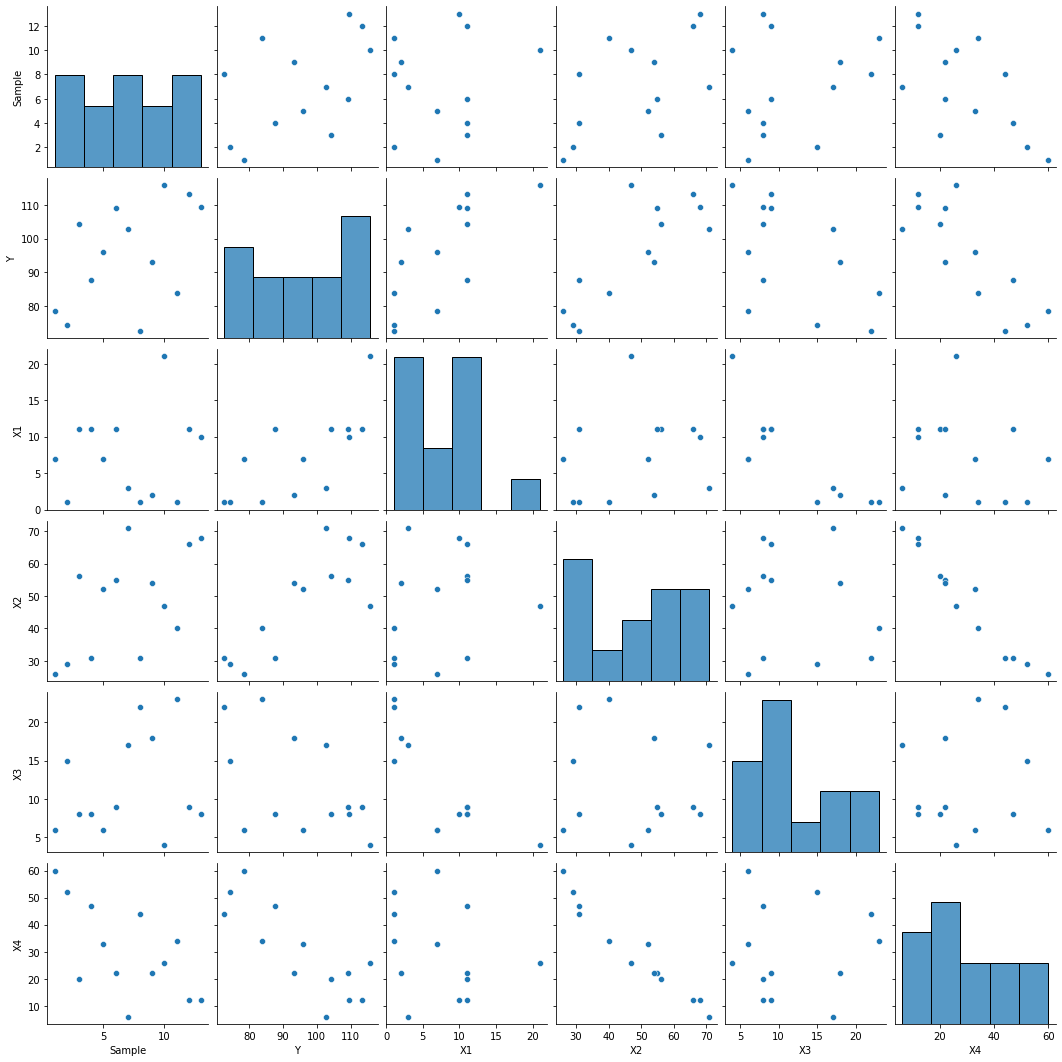

In [1]:
import pandas as pd
import statsmodels.api as sm

data=pd.read_csv('ex9-6.csv')
data.head(4)

import seaborn as sns
sns.pairplot(data = data)
data.corr()

In [2]:
# 비표준화 회귀분석
import pandas as pd
import statsmodels.formula.api as smf
fit1=smf.ols('Y~X1+X2+X3+X4', data).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     111.5
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           4.76e-07
Time:                        07:43:51   Log-Likelihood:                -26.918
No. Observations:                  13   AIC:                             63.84
Df Residuals:                       8   BIC:                             66.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.4054     70.071      0.891      0.3

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [3]:
# vif-통계량 계산
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
y, X = dmatrices('Y ~ X1 + X2 + X3 + X4', data, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,10668.509471,Intercept
1,38.496211,X1
2,254.423166,X2
3,46.868386,X3
4,282.512865,X4


In [4]:
## 변수선택방법(전진법)
y=data.Y
#         0       1     2  3~6
# data (index, sample, Y, X1-X4)
X=data.iloc[:,2:6]

def forward(X, y, level, verbose=False): #전진선택법
    initial_list=[]
    included=list(initial_list)    #선택된 변수를 저장할 리스트
    while True:
        changed=False
        excluded=list(set(X.columns)-set(included))     #(전체변수-선택된 변수)=남은변수 저장
        pval=pd.Series(index=excluded, dtype='float64')  ## 변수의 p-value 저장

        for col in excluded:
            if  (len(included)==0):
                model=sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[col]]))).fit()
            else:
                model=sm.OLS(y, pd.DataFrame(X[included+[col]])).fit()
            pval[col]=model.pvalues[col]
        best_pval=pval.min()

        if best_pval < level:  #유의수준과 p-value를 비교해서 작으면 해당 변수를 모형에 포함
            best_X=pval.idxmin()
            included.append(best_X)
            changed=True

            if verbose:
                print('ADD{:20} with p-val{:25}'.format(best_X, best_pval))
        if not changed:
            break
    return included      #최종 선택 변수 출력

forward(X, y, 0.05, verbose=True)    #데이터의 반응변수와 데이터 이름 입력

ADDX4                   with p-val    0.0005762318164885019
ADDX2                   with p-val    5.674585310536363e-10
ADDX1                   with p-val    3.404795200209698e-05
ADDX3                   with p-val    0.0010367059700242996


['X4', 'X2', 'X1', 'X3']

In [5]:
## 변수선택법(backward)
def backward(X, y, level, verbose=False): #후진선택법
    included=list(X.columns)    #선택된 변수를 저장할 리스트
    while True:
        changed=False
        if  (len(included)==1):
            model=sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        else:
            model=sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pval=model.pvalues.iloc[1:]
        worst_pval=pval.max()

        if worst_pval > level:  #유의수준과 p-value를 비교해서 작으면 해당 변수를 모형에 포함
            changed = True
            worst_X=pval.idxmax()
            included.remove(worst_X)

            if verbose:
                print('DROP{:20} with p-val{:25}'.format(worst_X, worst_pval))
        if not changed:
            break
    return included      #최종 선택 변수 출력

backward(X, y, 0.05, verbose=True)    #데이터의 반응변수와 데이터 이름 입력

DROPX3                   with p-val       0.8959226905101331
DROPX4                   with p-val      0.20539543810169256


['X1', 'X2']

In [6]:
# 수정된 회귀분석
fit2=smf.ols('Y~X1+X2', data).fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     229.5
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           4.41e-09
Time:                        07:54:52   Log-Likelihood:                -28.156
No. Observations:                  13   AIC:                             62.31
Df Residuals:                      10   BIC:                             64.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.5773      2.286     22.998      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [7]:
# vif-통계량 계산
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
y, X = dmatrices('Y ~ X1 + X2', data, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,11.734102,Intercept
1,1.055129,X1
2,1.055129,X2


In [8]:
# 수정된 회귀분석
fit2=smf.ols('Y~X1+X2', data).fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     229.5
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           4.41e-09
Time:                        07:58:17   Log-Likelihood:                -28.156
No. Observations:                  13   AIC:                             62.31
Df Residuals:                      10   BIC:                             64.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.5773      2.286     22.998      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [16]:
data['EDU_DUM1']=0    # 더비변수 처리
data.loc[data['EDU']==1, 'EDU_DUM1']=1

data['EDU_DUM2']=0    # 더미변수 처리
data.loc[data['EDU']==2, 'EDU_DUM2']=1

data.head()

,SEX,EDU,YEAR,SAL,EDU_DUM1,EDU_DUM2
0,0,1,6.0,195,1,0
1,1,1,4.0,190,1,0
2,1,2,4.5,225,0,1
3,0,3,5.5,220,0,0
4,0,2,3.0,205,0,1


In [17]:
fit=smf.ols('SAL~SEX+EDU_DUM1+EDU_DUM2+YEAR', data).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAL   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     30.35
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000163
Time:                        16:01:08   Log-Likelihood:                -37.611
No. Observations:                  12   AIC:                             85.22
Df Residuals:                       7   BIC:                             87.65
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    192.5585     12.410     15.517      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
#----------------------아래부터 시험범위 아님---------------------

In [18]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

x=np.array([65,34,40,80,30,57,72,48])
y=np.array([2.57,4.40,4.52,1.39,4.75,3.55,2.49,3.77])

d={'y':y, 'x':x}
data=pd.DataFrame(data=d)

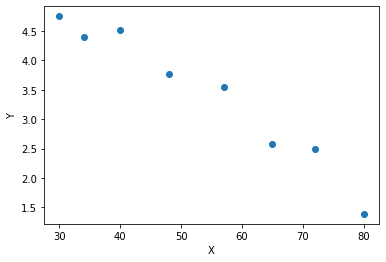

In [19]:
#산점도
import matplotlib.pylab as plt
plt.plot(data['x'], data['y'], 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [20]:
#Z변수 추가
data['Z']=0
data.loc[data['x']>=50, 'Z']=1
data['x50z']=(x-50)*data['Z']

data.head()

,y,x,Z,x50z
0,2.57,65,1,15
1,4.40,34,0,0
2,4.52,40,0,0
3,1.39,80,1,30
4,4.75,30,0,0


In [21]:
#단순회귀분석
fit1=smf.ols('y~x', data).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     118.8
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.53e-05
Time:                        16:04:19   Log-Likelihood:              -0.016565
No. Observations:                   8   AIC:                             4.033
Df Residuals:                       6   BIC:                             4.192
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7946      0.324     20.963      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [22]:
#꺾은선 회귀분석
fit2=smf.ols('y~x+x50z', data).fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     79.06
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000165
Time:                        16:06:43   Log-Likelihood:                 1.7825
No. Observations:                   8   AIC:                             2.435
Df Residuals:                       5   BIC:                             2.673
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8954      0.604      9.757      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [23]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

x=np.array([225,350,150,200,175,180,325,290,400,125])
y=np.array([11.95,14.13,8.93,10.98,10.03,10.13,13.75,13.30,15.00,7.97])
d={'y':y, 'x':x}
data=pd.DataFrame(data=d)

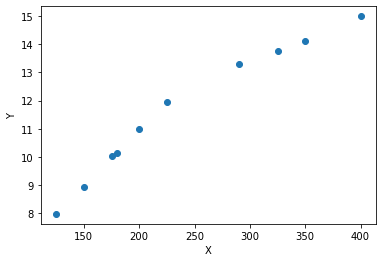

In [24]:
#산점도
import matplotlib.pylab as plt
plt.plot(data['x'], data['y'], 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [26]:
#Z변수 추가
data['U']=0
data.loc[data['x']>250, 'U']=1
data['V']=0
data.loc[data['x']>250, 'V']=1
data['x250u']=(x-250)*data['U']
data.head()

,y,x,U,V,x250u
0,11.95,225,0,0,0
1,14.13,350,1,1,100
2,8.93,150,0,0,0
3,10.98,200,0,0,0
4,10.03,175,0,0,0


In [27]:
#단순회귀분석
fit1=smf.ols('y~x', data).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     193.5
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           6.90e-07
Time:                        16:13:41   Log-Likelihood:                -6.1944
No. Observations:                  10   AIC:                             16.39
Df Residuals:                       8   BIC:                             16.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5724      0.463     12.044      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [28]:
#점프 회귀분석
fit2=smf.ols('y~x+x250u+V', data).fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     6377.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           6.74e-11
Time:                        16:13:50   Log-Likelihood:                 18.011
No. Observations:                  10   AIC:                            -28.02
Df Residuals:                       6   BIC:                            -26.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9629      0.116     25.445      0.0

C:\Users\gksxk\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
